In [1]:
%matplotlib inline 

# Association Rule Mining
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)
* [Product Investigation](#product)
* [Aisle Investigation](#aisle)
* [Department Investigation](#department)
* [Summary](#summary)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Association Rule Mining on the Instacart Data. Note no quantity of item analysis is complete, only a one hot whether an item appears or not.

A note on the aisle and department investigation , Ilooked into doing some form of weighting (more advanced than absent/present method) however I was unsucessful in finding a Library that could do that. mlxtend is fair basic in what it can accomodate and the only other library I found for association rules was : https://pypi.org/project/Orange3-Associate/ Organse3-Associate which seemed to have limited capabilities also. I could have written my own algorithm for it but I did not want to go down this rabbit hole as may have ended badly/prove a waste of time.

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [4]:
te = TransactionEncoder()

In [5]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

In [6]:
orders = read_csv_file(my_orders_file)
orders.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12202,472199,765,prior,1,2,21,NaN
1,12203,1424394,765,prior,2,1,21,20.0
2,12204,889292,765,prior,3,6,21,30.0
3,12205,2809253,765,prior,4,3,20,30.0
4,12206,2392861,765,prior,5,1,12,19.0


In [7]:
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,147221,15511,429,1,0
1,147222,15511,46397,2,0
2,147223,15511,27323,3,0
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0


In [8]:
products = read_csv_file(products_file)
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
departments = read_csv_file(departments_file)
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
aisles = read_csv_file(aisles_file)
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Product Investigation <a class="anchor" id="product"></a>
***

### Product Number Counts

In [11]:
product_order_frequency = (orders_products
                           .groupby("product_id")
                           .size()
                           .reset_index(name="count")
                           .sort_values(by=['count'], ascending=False)
                          )
order_count_total = orders.shape[0]
print("Total Orders :", order_count_total)
max_product_count = product_order_frequency["count"].max()
min_product_count = product_order_frequency["count"].min()
print("Product Order Count Max :", max_product_count)
print("Product Order Count Min :", min_product_count)
mean_order_frequency = round(product_order_frequency["count"].mean())
print("Product Order Count Average :", mean_order_frequency)
print("Product Order Count Median :", product_order_frequency["count"].median())
print("Product Order Count Mode :", product_order_frequency["count"].mode()[0])

Total Orders : 306
Product Order Count Max : 67
Product Order Count Min : 1
Product Order Count Average : 3.0
Product Order Count Median : 1.0
Product Order Count Mode : 1


### Grouping Products in an Order

In [12]:
# Can't just use a comma as a seperator
weird_separator = ",#,"
def products_ordered_to_total(products_ordered):
    group = products_ordered.groupby('order_id')
    product_count = group.size().reset_index(name="count")
    product_names = group["product_name"].apply(lambda x: "%s" % weird_separator.join(x)).reset_index(name="products")
    products_ordered_total = (product_count.merge(product_names, on="order_id"))
    return products_ordered_total
products_ordered = orders_products.merge(products, on="product_id")
products_ordered_total = products_ordered_to_total(products_ordered)
order_total = products_ordered_total.shape[0]
products_ordered_total.head()

,order_id,count,products
0,15511,13,"Dark Red Kidney Beans,#,Reduced Sodium Great N..."
1,22082,3,"Organic Extra Large Brown Eggs,#,Organic Fruit..."
2,26712,14,"Gluten Free Breaded Chicken Breast Tenders,#,1..."
3,27068,14,"Yellow Onions,#,Red Peppers,#,Yellow Bell Pepp..."
4,49162,9,"Bunched Cilantro,#,Red Peppers,#,Yellow Bell P..."


### Product - Calculate Decent Support Value

In [13]:
# For support values
# Suck it and see approach to get min desired appearance
min_desired_times_ordered = 10
min_support = round(min_desired_times_ordered/order_total, 4)
print("Minimum times ordered to be considered :", min_desired_times_ordered)
print("Minimum Support :", min_support)

Minimum times ordered to be considered : 10
Minimum Support : 0.0331


### Product - Transaction Database Boolean Array

In [14]:
def product_list_to_te_df(product_list):
    products_ordered_list_of_lists = []
    for p in product_list:
        products_ordered_list_of_lists.append(p.split(weird_separator))
    te_ary = te.fit(products_ordered_list_of_lists).transform(products_ordered_list_of_lists,sparse=False)
    te_df = pd.DataFrame(te_ary, columns=te.columns_)
    return te_df
te_df = product_list_to_te_df(products_ordered_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,Yellow Peaches,YoBaby Peach Pear Yogurt,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry",Yobaby Organic Plain Yogurt,Yogurt Tubes Blueberry,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,ZBar Organic Chocolate Brownie Energy Snack,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Product - First 100 transactions vs items

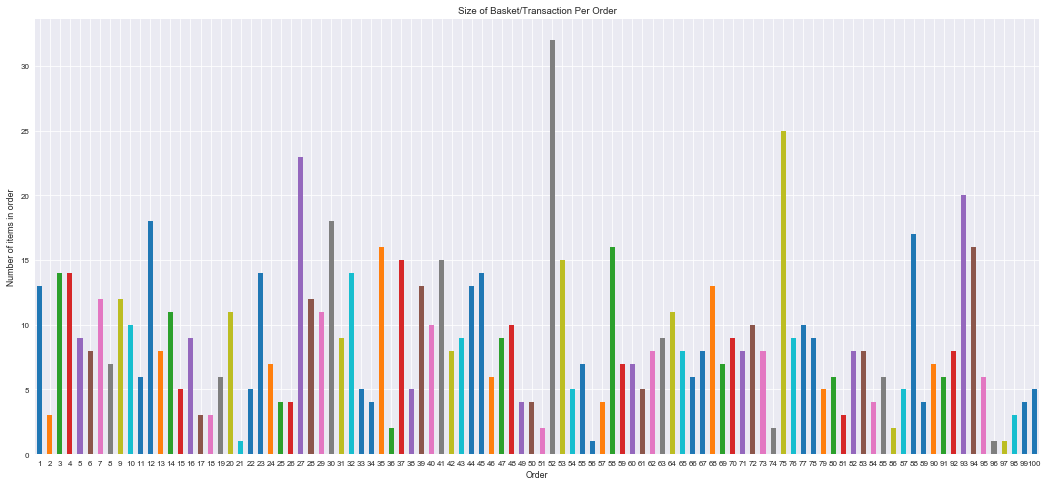

In [15]:
transaction_limit = 100
the_range = list(range(1, transaction_limit + 1))
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
products_ordered_total["count"].head(transaction_limit).plot.bar()
ax.set_xticklabels(the_range, rotation='horizontal')
plt.title("Size of Basket/Transaction Per Order")
plt.ylabel("Number of items in order")
plt.xlabel("Order")
plt.show()

Bar plot may not best illustrate this but does show that the number of items per transactions fluctuates between 1 and 33 for the first 100 transactions.

### Product - Distribution of Transaction size

In [16]:
# Generate plot of count of the number of transactions of the same size
a = (products_ordered_total[["count"]]
     .groupby("count")
     .size()
     .reset_index(name="counts")
     .sort_values(by="counts", ascending=False)
    )
a.head()

,count,counts
8,9,28
4,5,25
7,8,22
9,10,22
2,3,21


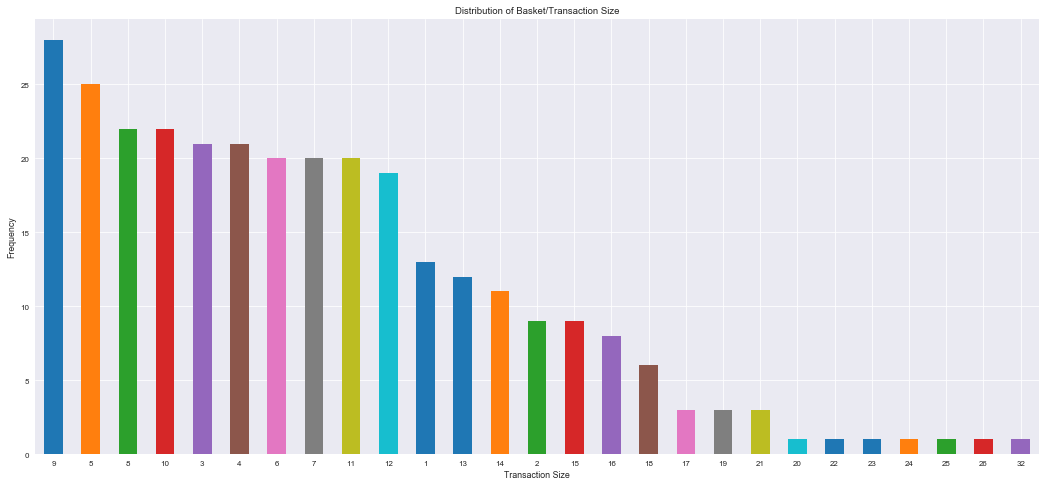

In [17]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
a['counts'].plot.bar()
ax.set_xticklabels(a["count"], rotation='horizontal')
plt.title("Distribution of Basket/Transaction Size")
plt.ylabel("Frequency")
plt.xlabel("Transaction Size")
plt.show()

The most often number of items ordered is 9 followed by 5, then 8. From a speculation perspective I would have though that between 1 and 3 items would have been more frequent with the logic that people buy small amount of items online often.

### Product - Frequent Itemsets - Apriori

In [18]:
frequent_itemsets = (apriori(te_df, min_support=min_support,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0331  support : 121


,support,itemsets
1,0.221854,[2% Reduced Fat Organic Milk]
46,0.175497,[Vanilla Almond Breeze]
64,0.165563,"[2% Reduced Fat Organic Milk, Vanilla Almond B..."
11,0.139073,[Granny Smith Apples]
2,0.129139,[Banana]


### Product - Support for most Frequeny products

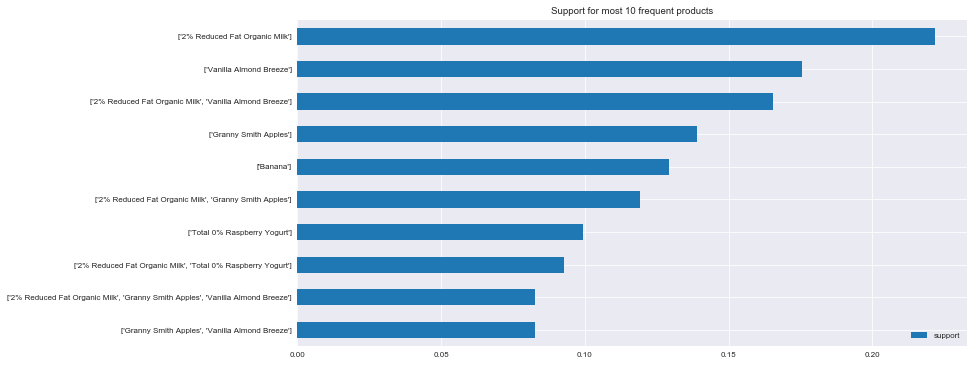

In [19]:
min_numer_to_show = 10
frequent_itemsets.head(min_numer_to_show).plot.barh(title ="Support for most " + str(min_numer_to_show) +  " frequent products")
plt.yticks(range(min_numer_to_show), frequent_itemsets["itemsets"].head(min_numer_to_show))
plt.gca().invert_yaxis()
plt.show()

### Product Rule Generation

####  Rule Generation by Lift

In [20]:
min_lift = 5
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head(10)

Number of Generated Rules via lift : 154  min value of lift :  5


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(Total 2% Greek Strained Yogurt with Cherry 5....,(Vanilla Almond Breeze),0.043046,0.175497,0.043046,1.000000,5.698113,0.035492,inf
85,(Total 2% Lowfat Greek Strained Yogurt With Bl...,"(Total 0% Raspberry Yogurt, 2% Reduced Fat Org...",0.039735,0.092715,0.039735,1.000000,10.785714,0.036051,inf
77,(Total 2% Lowfat Greek Strained Yogurt With Bl...,(Total 0% Raspberry Yogurt),0.039735,0.099338,0.039735,1.000000,10.066667,0.035788,inf
81,"(2% Reduced Fat Organic Milk, Total 2% Lowfat ...",(Total 0% Raspberry Yogurt),0.039735,0.099338,0.039735,1.000000,10.066667,0.035788,inf
48,"(Total 0% Raspberry Yogurt, 2% Reduced Fat Org...",(Vanilla Almond Breeze),0.039735,0.175497,0.039735,1.000000,5.698113,0.032762,inf
109,(Premium Lager Beer),(Lager),0.036424,0.039735,0.036424,1.000000,25.166667,0.034977,inf
13,(Total 2% Lowfat Greek Strained Yogurt With Bl...,(Total 0% Raspberry Yogurt),0.052980,0.099338,0.049669,0.937500,9.437500,0.044406,14.410596
17,"(2% Reduced Fat Organic Milk, Total 2% Lowfat ...",(Total 0% Raspberry Yogurt),0.049669,0.099338,0.046358,0.933333,9.395556,0.041424,13.509934
29,(Total 2% Greek Strained Yogurt with Cherry 5....,(Total 0% Raspberry Yogurt),0.046358,0.099338,0.043046,0.928571,9.347619,0.038441,12.609272
40,(Total 2% Greek Strained Yogurt with Cherry 5....,"(2% Reduced Fat Organic Milk, Vanilla Almond B...",0.046358,0.165563,0.043046,0.928571,5.608571,0.035371,11.682119


Premium lager and normal lager bought together, not very interesting. Yogurt and low fat products bought together also not very interesting. Need to roll up the organic items into an organic category

#### Rule Generation by Confidence

In [21]:
min_conf = 0.8
conf_rules = (association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via confidence :", conf_rules.shape[0], " min confidence :", min_conf)
conf_rules.head(10)

Number of Generated Rules via confidence : 85  min confidence : 0.8


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,"(Granny Smith Apples, Vanilla Almond Breeze)",(2% Reduced Fat Organic Milk),0.082781,0.221854,0.082781,1.0,4.507463,0.064416,inf
5,"(Total 0% Raspberry Yogurt, Vanilla Almond Bre...",(2% Reduced Fat Organic Milk),0.076159,0.221854,0.076159,1.0,4.507463,0.059263,inf
8,(Cherry Pomegranate Greek Yogurt),(2% Reduced Fat Organic Milk),0.056291,0.221854,0.056291,1.0,4.507463,0.043803,inf
13,"(Granny Smith Apples, Cherry Pomegranate Greek...",(2% Reduced Fat Organic Milk),0.049669,0.221854,0.049669,1.0,4.507463,0.038650,inf
26,(Total 2% Greek Strained Yogurt with Cherry 5....,(Vanilla Almond Breeze),0.043046,0.175497,0.043046,1.0,5.698113,0.035492,inf
22,"(Total 0% Raspberry Yogurt, Granny Smith Apple...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
25,"(Total 0% Raspberry Yogurt, Cherry Pomegranate...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
27,(Total 2% Greek Strained Yogurt with Cherry 5....,(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
29,"(Fat Free Strawberry Yogurt, Vanilla Almond Br...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
57,(Total 2% Lowfat Greek Strained Yogurt With Bl...,"(Total 0% Raspberry Yogurt, 2% Reduced Fat Org...",0.039735,0.092715,0.039735,1.0,10.785714,0.036051,inf


Very similar results as using the min lift

### Product - Organic Rollup Attempt

In [22]:
orders_products_product_details = orders_products.merge(products, on="product_id")
orders_products_product_details.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


### Organic Products

In [23]:
# Took this approach as this was less computation than using the full products list
organic_products_ordered = orders_products_product_details[orders_products_product_details['product_name'].str.contains("Organic")]
print("Organic Products Ordered :", organic_products_ordered.shape[0])
organic_products_ordered.head()

Organic Products Ordered : 648


,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
49,253765,26712,32467,9,0,Organic Living Butter Lettuce,83,4
50,253766,26712,27625,10,0,Organic Lady Alice Apples,24,4
53,253769,26712,18811,13,0,Organic Apple Juice,98,7
92,257079,27068,890,3,0,Organic Diced Tomatoes,81,15
93,4575555,482965,890,24,0,Organic Diced Tomatoes,81,15


In [24]:
organic_products_ordered_aisle = organic_products_ordered.merge(aisles, on="aisle_id")
organic_products_ordered_aisle.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,253765,26712,32467,9,0,Organic Living Butter Lettuce,83,4,fresh vegetables
1,257080,27068,24964,4,0,Organic Garlic,83,4,fresh vegetables
2,4575554,482965,24964,23,1,Organic Garlic,83,4,fresh vegetables
3,5434953,573593,24964,10,0,Organic Garlic,83,4,fresh vegetables
4,9423698,994761,24964,4,1,Organic Garlic,83,4,fresh vegetables


### Product Rollup Note
Below is my product roll up procedure which is not very smart as it takes each item very specifically such as organic, or yogurt are specifically coded for, the only smart way I could think of rolling items up is by aisle but as this will be investigated later I did not see the point in doing that now.

### The organic rollup logic - probably not very efficient

In [25]:
orders_products_product_details_organic_rollup = orders_products_product_details.copy()
aisle_id_list = organic_products_ordered_aisle.aisle_id.unique().tolist()
for aisle_id in aisle_id_list :
    df = organic_products_ordered_aisle.query("aisle_id == " + str(aisle_id))
    organic_title = "Organic " + df.aisle.unique().tolist()[0]
    for index, row in df.iterrows():
        orders_products_product_details_organic_rollup.loc[orders_products_product_details_organic_rollup['Unnamed: 0'] == row["Unnamed: 0"], 'product_name'] = organic_title
orders_products_product_details_organic_rollup.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


In [26]:
organic_rollup_products_total = products_ordered_to_total(orders_products_product_details_organic_rollup)
te_df = product_list_to_te_df(organic_rollup_products_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,XL Symphony Candy Bar,Yellow Bell Pepper,Yellow Onions,Yellow Peaches,YoBaby Peach Pear Yogurt,Yogurt Tubes Blueberry,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


From 962 to 816 columns due to the organic rollups

### Product - Rollup the Yogurts

In [27]:
rollup_with_yogurt = orders_products_product_details_organic_rollup.copy()
yogurts_ordered = rollup_with_yogurt[rollup_with_yogurt['product_name'].str.contains("Yogurt")]
for index, row in yogurts_ordered.iterrows():
    rollup_with_yogurt.loc[rollup_with_yogurt['Unnamed: 0'] == row["Unnamed: 0"], 'product_name'] = "Yogurt"
rollup_with_yogurt.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


In [28]:
rollup_with_yogurt_total = products_ordered_to_total(rollup_with_yogurt)
te_df = product_list_to_te_df(rollup_with_yogurt_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,XL Emerald White Seedless Grapes,XL Symphony Candy Bar,Yellow Bell Pepper,Yellow Onions,Yellow Peaches,Yogurt,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


From 816 to 788 with the yogurt rollup - not a massive gain but yogurt was frequent enough with the association rule

### Product - Remove Milk
As 'organic' milk is a very general and popular item, just going to remove it from the rollup as it would be rare if something interesting is bough with milk

In [29]:
rollup_without_organic_milk = rollup_with_yogurt.copy()
rollup_without_organic_milk = rollup_without_organic_milk[rollup_without_organic_milk.product_name != "Organic milk"]
rollup_without_organic_milk.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


In [30]:
rollup_without_organic_milk_total = products_ordered_to_total(rollup_without_organic_milk)
te_df = product_list_to_te_df(rollup_without_organic_milk_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,XL Emerald White Seedless Grapes,XL Symphony Candy Bar,Yellow Bell Pepper,Yellow Onions,Yellow Peaches,Yogurt,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


Dropped only one product item so makes sense it would go from 788 to 787 columns

### Product Rollup Frequent Items

In [31]:
frequent_itemsets = (apriori(te_df, min_support=min_support,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0331  support : 73


,support,itemsets
41,0.258278,[Yogurt]
23,0.241722,[Organic fresh vegetables]
36,0.175497,[Vanilla Almond Breeze]
21,0.172185,[Organic fresh fruits]
27,0.155629,[Organic packaged vegetables fruits]


It can be seen that due to the rollup or oganic it is appearing alot in the frequent item sets

### Product Rollup Rules

In [32]:
min_lift = 1
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head(20)

Number of Generated Rules via lift : 72  min value of lift :  1


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,(Premium Lager Beer),(Lager),0.036424,0.039735,0.036424,1.000000,25.166667,0.034977,inf
48,"(Red Peppers, Organic packaged vegetables fruits)",(Organic fresh vegetables),0.036424,0.241722,0.036424,1.000000,4.136986,0.027619,inf
67,"(Organic eggs, Red Peppers)",(Organic fresh vegetables),0.033113,0.241722,0.033113,1.000000,4.136986,0.025109,inf
26,(Boneless Skinless Chicken Breasts),(Organic fresh vegetables),0.046358,0.241722,0.043046,0.928571,3.841487,0.031841,10.615894
44,(Lager),(Premium Lager Beer),0.039735,0.036424,0.036424,0.916667,25.166667,0.034977,11.562914
9,(Red Peppers),(Organic fresh vegetables),0.076159,0.241722,0.066225,0.869565,3.597379,0.047816,5.813466
37,(Organic canned jarred vegetables),(Organic fresh vegetables),0.046358,0.241722,0.039735,0.857143,3.545988,0.028529,5.307947
59,(Organic juice nectars),(Organic fresh vegetables),0.039735,0.241722,0.033113,0.833333,3.447489,0.023508,4.549669
20,(Organic eggs),(Organic fresh vegetables),0.059603,0.241722,0.049669,0.833333,3.447489,0.035262,4.549669
60,(Yellow Bell Pepper),(Organic fresh vegetables),0.043046,0.241722,0.033113,0.769231,3.182297,0.022707,3.285872


### Product Assication Rule Conclusion
Unfortunately no particularly interesting rules were found, this is probably due to the size of the data set being used, alternatively is also due to the constringent parameters I used. From the non product rollup investigation (both the confidence and lift approach) it is clear that milk and yogurt is bought frequently, this is fairly common in a weekly grocery shop.

From the rollup assication rule there are some very obvious rules such as Lager is bought with more premium lager.

If someone buys Red Peppers and Organic packaged vegetables fruits then they are likely to buy Organic fresh vegetables , again not overly interesting.

The only somewhat interesting rules are perhaps Granny Smith Apples  (with or without Yogurt) is often bough with Almond milk (Vanilla Almond Breeze), makes sense but most of the association rules appear very similar for these 'health' foods.

Again could have rolled up the fruit by the aisle but as the aisle has its own investigation I didn't want to do more or less the same investigation twice.

## Aisle Investigation <a class="anchor" id="aisle"></a>
***

In [33]:
group = products_ordered.groupby(['order_id','aisle_id'])
aisle_count = group.size().reset_index(name="aisle_count")
aisle_count = aisle_count.merge(aisles, on="aisle_id")
# Number of times aisle appear in an order, now to group the unique aisles in an order
aisle_count.head()

,order_id,aisle_id,aisle_count,aisle
0,15511,16,1,fresh herbs
1,49162,16,1,fresh herbs
2,140874,16,1,fresh herbs
3,195875,16,1,fresh herbs
4,266611,16,1,fresh herbs


In [34]:
group = aisle_count.groupby('order_id')
count = group.size().reset_index(name="count")
names = group["aisle"].apply(lambda x: "%s" % weird_separator.join(x)).reset_index(name="aisle")
aisle_order_total = (count.merge(names, on="order_id"))
aisle_order_total.head()

,order_id,count,aisle
0,15511,8,"fresh herbs,#,beers coolers,#,canned meals bea..."
1,22082,3,"eggs,#,juice nectars,#,bread"
2,26712,10,"fresh vegetables,#,juice nectars,#,fresh fruit..."
3,27068,7,"fresh vegetables,#,eggs,#,bread,#,packaged che..."
4,49162,5,"fresh herbs,#,fresh vegetables,#,fresh fruits,..."


### Aisle - Transaction Database Boolean Array

In [35]:
aisles_ordered_list_of_lists = []
for aisle in aisle_order_total.aisle.tolist():
    aisles_ordered_list_of_lists.append(aisle.split(weird_separator))
te_ary = te.fit(aisles_ordered_list_of_lists).transform(aisles_ordered_list_of_lists,sparse=False)
te_df = pd.DataFrame(te_ary, columns=te.columns_)
te_df.head()

,asian foods,baby accessories,baby food formula,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,...,specialty wines champagnes,spices seasonings,spreads,tea,tofu meat alternatives,tortillas flat bread,trash bags liners,vitamins supplements,water seltzer sparkling water,yogurt
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Aisle - First 100 transactions vs items (number of aisles)

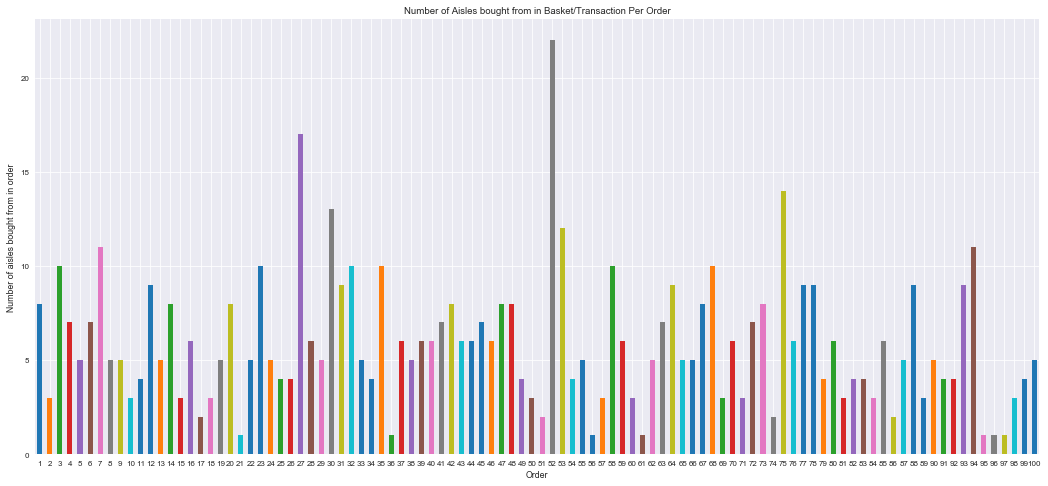

In [36]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
aisle_order_total["count"].head(transaction_limit).plot.bar()
ax.set_xticklabels(the_range, rotation='horizontal')
plt.title("Number of Aisles bought from in Basket/Transaction Per Order")
plt.ylabel("Number of aisles bought from in order")
plt.xlabel("Order")
plt.show()

Bar plot may not best illustrate this but does show that the number of aisles visited per transaction fluctuates between 1 and 23 for the first 100 transactions. This is a very similar graph to the one obtained in the product investigation which makes sense as it's the same data just looking at the aisles the customer went to rather than the products

### Aisle - Distribution of Transaction size

In [37]:
# Generate plot of the count of the number of transactions of the same size
a = (aisle_order_total[["count"]]
     .groupby("count")
     .size()
     .reset_index(name="counts")
     .sort_values(by="counts", ascending=False)
    )
a.head()

,count,counts
4,5,46
5,6,37
3,4,35
2,3,34
6,7,30


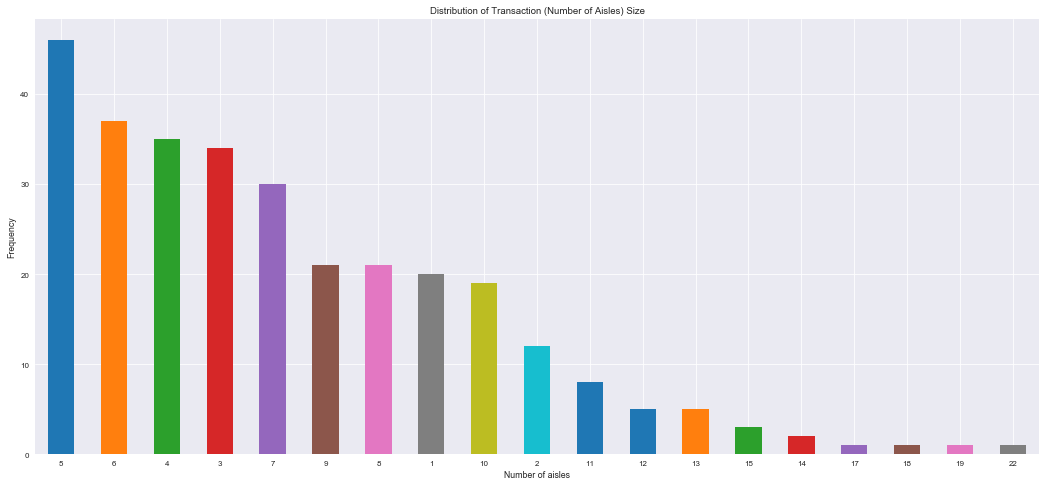

In [38]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
a['counts'].plot.bar()
ax.set_xticklabels(a["count"], rotation='horizontal')
plt.title("Distribution of Transaction (Number of Aisles) Size")
plt.ylabel("Frequency")
plt.xlabel("Number of aisles")
plt.show()

As can be seen the most occuring number of aisles is 5 followed by 6 then 4 and then 3 (larger drop after 3, also big drop from 5 to 6). So it is clear a lot of customers spend their time shopping between 3 to 6 aisles before purchasing and leaving. Of course customers may go through aisles and not buy items which cannot be told from this data.

Where this information is useful is shop organisation so if there are 2 or 3 aisles where most customers do their shopping, put in an aisle in between them so customers may also visit that aisle in passing and as a result buy more products.

### Aisle - Frequent Itemsets - Apriori

In [39]:
# Kept min support the same I wanted the item/aisle to appear 10 times at least in the overall whole orders to be investigated
frequent_itemsets = (apriori(te_df, min_support=min_support,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0331  support : 267


,support,itemsets
17,0.486755,[fresh fruits]
29,0.397351,[milk]
19,0.380795,[fresh vegetables]
35,0.307947,[packaged vegetables fruits]
48,0.264901,[yogurt]


### Aisle Rule Generation - Using Lift

In [40]:
# Took a suck it and see approach, anything over 2 gives very few results
min_lift = 2
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head(20)

Number of Generated Rules via lift : 260  min value of lift :  2


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
31,(canned meals beans),(fresh vegetables),0.066225,0.380795,0.066225,1.000000,2.626087,0.041007,inf
129,"(canned meals beans, fresh fruits)",(fresh vegetables),0.039735,0.380795,0.039735,1.000000,2.626087,0.024604,inf
138,"(canned jarred vegetables, fresh fruits)",(fresh vegetables),0.036424,0.380795,0.036424,1.000000,2.626087,0.022554,inf
242,"(canned jarred vegetables, eggs)",(fresh vegetables),0.033113,0.380795,0.033113,1.000000,2.626087,0.020503,inf
200,"(soy lactosefree, spreads)",(milk),0.033113,0.397351,0.033113,1.000000,2.516667,0.019955,inf
232,"(bread, cereal)",(milk),0.033113,0.397351,0.033113,1.000000,2.516667,0.019955,inf
246,"(yogurt, cereal)",(fresh fruits),0.033113,0.486755,0.033113,1.000000,2.054422,0.016995,inf
16,"(soy lactosefree, fresh fruits, yogurt)",(milk),0.072848,0.397351,0.069536,0.954545,2.402273,0.040590,13.258278
4,"(soy lactosefree, yogurt)",(milk),0.099338,0.397351,0.092715,0.933333,2.348889,0.053243,9.039735
60,"(soy lactosefree, bread)",(milk),0.049669,0.397351,0.046358,0.933333,2.348889,0.026622,9.039735


Overall nothing astoishing here from a single row however, if we look at cereal and bread to milk and spreads, soy lactosefree to milk it can be seen they have the same support , confidence and leverage showing that the rule of cereal, bread and milk (which is fairly well known/common) is also present for our lactose/gluten intolerent friends.

Given the level of research that has gone into data mining grocery items its hard to actually find anything novel that does not appear as common sense. For instance people who buy from cereal and yogurt also buy fresh fruits, probably to put into their yogurt (or cereal) so unless you're heavily against fresh fruit, this is probably not new information.

Of course the values may be too constringent however given that 260 rules are present, all of which have a positive relationship/interest factor (due to lift having to be a minimum of 1) it would be hard to manually filter through more rules manually.

## Department Investigation <a class="anchor" id="department"></a>
***

In [41]:
group = products_ordered.groupby(['order_id','department_id'])
deparmtne_count = group.size().reset_index(name="department_count")
deparmtne_count = deparmtne_count.merge(departments, on="department_id")
# Number of times department appears in an order, now to group the unique departments in an order
deparmtne_count.head()

,order_id,department_id,department_count,department
0,15511,1,1,frozen
1,26712,1,1,frozen
2,63012,1,1,frozen
3,108931,1,2,frozen
4,184739,1,1,frozen


In [42]:
group = deparmtne_count.groupby('order_id')
count = group.size().reset_index(name="count")
names = group["department"].apply(lambda x: "%s" % weird_separator.join(x)).reset_index(name="department")
department_order_total = (count.merge(names, on="order_id"))
department_order_total.head()

,order_id,count,department
0,15511,6,"frozen,#,produce,#,alcohol,#,canned goods,#,da..."
1,22082,3,"dairy eggs,#,bakery,#,beverages"
2,26712,7,"frozen,#,produce,#,dairy eggs,#,bakery,#,bever..."
3,27068,4,"produce,#,canned goods,#,dairy eggs,#,bakery"
4,49162,2,"produce,#,meat seafood"


### Department - Transaction Database Boolean Array

In [43]:
department_ordered_list_of_lists = []
for dep in department_order_total.department.tolist():
    department_ordered_list_of_lists.append(dep.split(weird_separator))
te_ary = te.fit(department_ordered_list_of_lists).transform(department_ordered_list_of_lists,sparse=False)
te_df = pd.DataFrame(te_ary, columns=te.columns_)
te_df.head()

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,pantry,personal care,pets,produce,snacks
0,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,True,True
1,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False
3,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False


### Department - First 100 transactions vs items (number of departments)

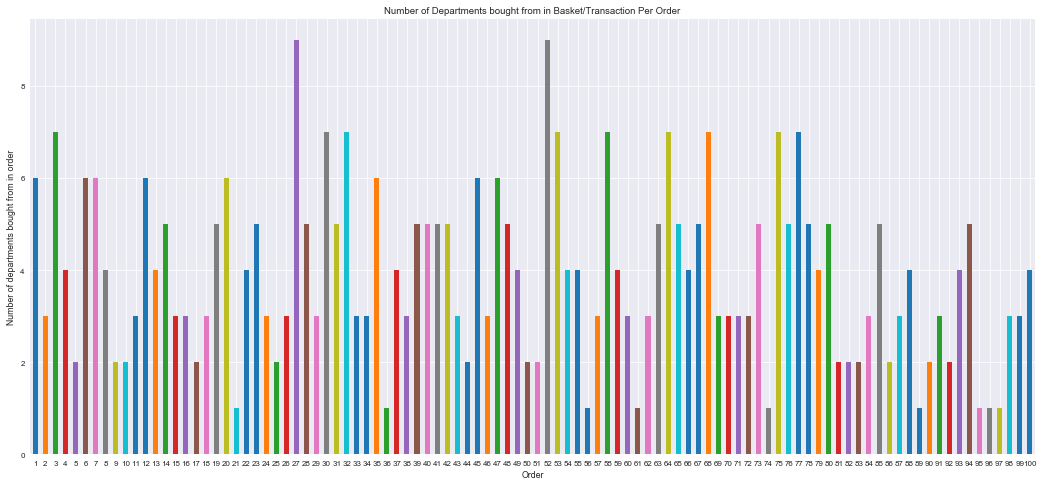

In [44]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
department_order_total["count"].head(transaction_limit).plot.bar()
ax.set_xticklabels(the_range, rotation='horizontal')
plt.title("Number of Departments bought from in Basket/Transaction Per Order")
plt.ylabel("Number of departments bought from in order")
plt.xlabel("Order")
plt.show()

As can be seen for the first 100 transactions, the deprtments bought from per order range from 1 to 9

### Department - Distribution of Transaction size

In [45]:
# Generate plot of the count of the number of transactions of the same size
a = (department_order_total[["count"]]
     .groupby("count")
     .size()
     .reset_index(name="counts")
     .sort_values(by="counts", ascending=False)
    )
a.head()

,count,counts
3,4,59
4,5,57
2,3,53
1,2,40
5,6,29


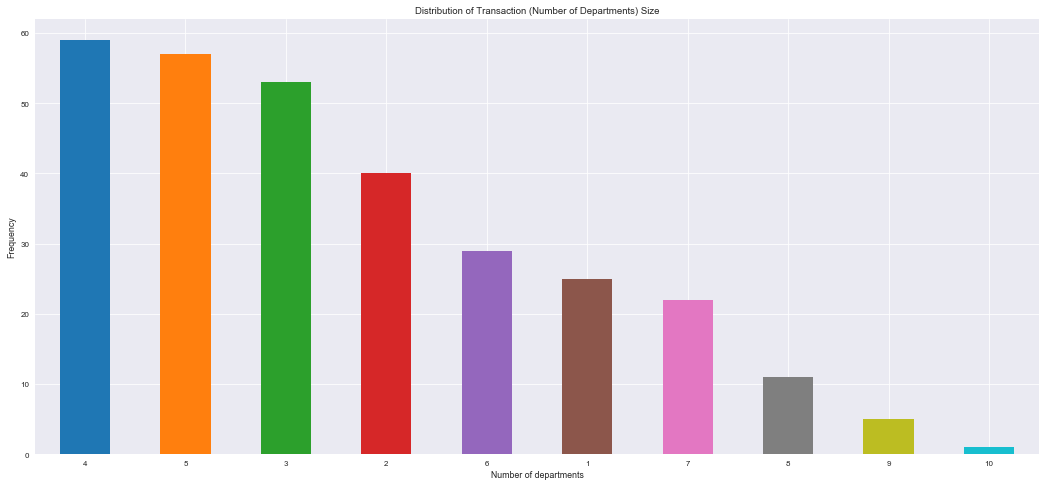

In [46]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
a['counts'].plot.bar()
ax.set_xticklabels(a["count"], rotation='horizontal')
plt.title("Distribution of Transaction (Number of Departments) Size")
plt.ylabel("Frequency")
plt.xlabel("Number of departments")
plt.show()

The most numbered shopped in departments are 4 then 5 and the 3 (large drop after that). Customers will therefore mostly shop inbetween 3 and 5 departments before paying and leaving.

### Department - Frequent Itemsets - Apriori

In [47]:
# Want a department to appear 5 times in the overall orders to be considered
min_support_dep = round(5/order_total, 4)
frequent_itemsets = (apriori(te_df, min_support=min_support_dep,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support_dep, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0166  support : 504


,support,itemsets
5,0.751656,[dairy eggs]
14,0.715232,[produce]
71,0.552980,"[dairy eggs, produce]"
2,0.453642,[beverages]
38,0.357616,"[beverages, dairy eggs]"


In [48]:
# Took a suck it and see approach, anything over 3 gives very few results
min_lift = 3
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head(20)

Number of Generated Rules via lift : 342  min value of lift :  3


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
108,"(beverages, frozen, meat seafood)","(snacks, dairy eggs)",0.023179,0.221854,0.023179,1.000000,4.507463,0.018036,inf
82,"(beverages, frozen, meat seafood)",(snacks),0.023179,0.307947,0.023179,1.000000,3.247312,0.016041,inf
106,"(beverages, frozen, meat seafood, dairy eggs)",(snacks),0.023179,0.307947,0.023179,1.000000,3.247312,0.016041,inf
301,"(beverages, produce, frozen, meat seafood)","(snacks, dairy eggs)",0.019868,0.221854,0.019868,1.000000,4.507463,0.015460,inf
216,"(dairy eggs, meat seafood, dry goods pasta)","(produce, snacks)",0.019868,0.241722,0.019868,1.000000,4.136986,0.015065,inf
156,"(beverages, produce, frozen, meat seafood)",(snacks),0.019868,0.307947,0.019868,1.000000,3.247312,0.013749,inf
207,"(dairy eggs, produce, meat seafood, dry goods ...",(snacks),0.019868,0.307947,0.019868,1.000000,3.247312,0.013749,inf
279,"(dairy eggs, meat seafood, dry goods pasta)",(snacks),0.019868,0.307947,0.019868,1.000000,3.247312,0.013749,inf
300,"(beverages, produce, frozen, meat seafood, dai...",(snacks),0.019868,0.307947,0.019868,1.000000,3.247312,0.013749,inf
72,"(beverages, frozen, canned goods)","(produce, bakery)",0.026490,0.258278,0.023179,0.875000,3.387821,0.016337,5.933775


As can be seen the snack department is fairly popular. What is interesting is that if a customer buys from the meat seafood, beverages and frozen departments they are likely to get from the snacks and dairy eggs department. However from reading below this entry and the corresponding support values it is clear that the eggs actually have very little to do with the consequents, more so if a customer buys from the meat seafood, beverages, frozen and dairy eggs department then they are likely to buy from snacks also. Given that these are groceries and a lot of people buy a variety of different snacks when doing their shopping not a whole lot to be gained here.

## Summary<a class="anchor" id="summary"></a>
***

Overall the approach that was taken was to look into the interest factor for rule generation and order by the highest confidence, support and lift. This may have "masked" some more interesting findings but given the level of rules generated it is hard to say whether investigating anymore would just give suprious results. In most cases I ordered the rules in the opposite direction and they were much the same (different support, lift etc. but basically the antecedants and consequents were reversed).

From a rolling up perspective an attempt was made to rollup organic products by giving anything organic it's relevant aisle, grouping yogurts and removing milk as milk would rarely give an unexpected result so milk (the most common 2% one) was removed to see if the rules generated from the pruning would be more interesting. Overall not really, health food is bought with health food, alcohol is bought with alcohol.

From the aisle perspective the main interesting thing found was that most orders happen between 3 to 6 aisles. As Instacart is an online shop not sure if that is useful information as regards positioning of aisles. From a rule perspective nothing overly interesting expcept possibly that cereal and bread to milk has the same support and lift as spreads and soy lactosefree to milk. Makes sense as lactosefree will have its own bread/cereal and require milk (of some variety), just interesting that is it exact same support, confidence and lift value.

From the department side not a whole lot can be drawn given that there is a small number of departments. Similarly people shop 3 to 6 aisles most frequently, they shop 3 to 5 deparments most frequently. From the rules the snack department seems to be the result of buying from a variety of deparments, people enjoy sugar I suppose.